# Forecasting Crime for 2025 with San Francisco's Police Incident Report Data

## Importing Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
import optuna

from statsmodels.graphics.tsaplots import plot_pacf
import holidays

## Load and Transform Data

Time Series Size: 2618


,count
datetime,
2018-01-01,203
2018-01-02,226
2018-01-03,265
2018-01-04,261
2018-01-05,335


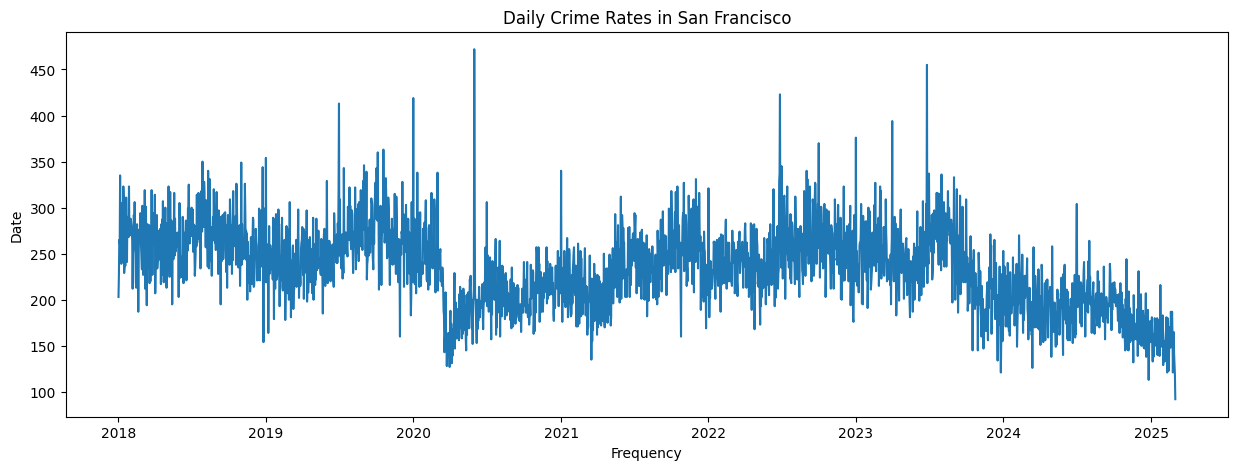

In [4]:
data = pd.read_csv('unified_dataset.csv', index_col=0)

# restore datetime from original dataset
original_data = pd.read_csv('Police_Department_Incident_Reports__2018_to_Present_20250303.csv')
data['datetime'] = original_data.iloc[data.index]['Incident Datetime']
del original_data

# round datetime to nearest day for aggregation
data['datetime'] = pd.to_datetime(data['datetime'], format="%Y/%m/%d %I:%M:%S %p").dt.round('d')

# convert to time series
ts = data['datetime'].value_counts().sort_index(ascending=True)
ts = pd.DataFrame(ts)[:-1] # ignore last day (incomplete)

print(f'Time Series Size: {len(ts)}')
display(ts.head(5))

# plot data
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(ts)
ax.set_title('Daily Crime Rates in San Francisco')
ax.set_xlabel('Frequency')
ax.set_ylabel('Date')

plt.show()

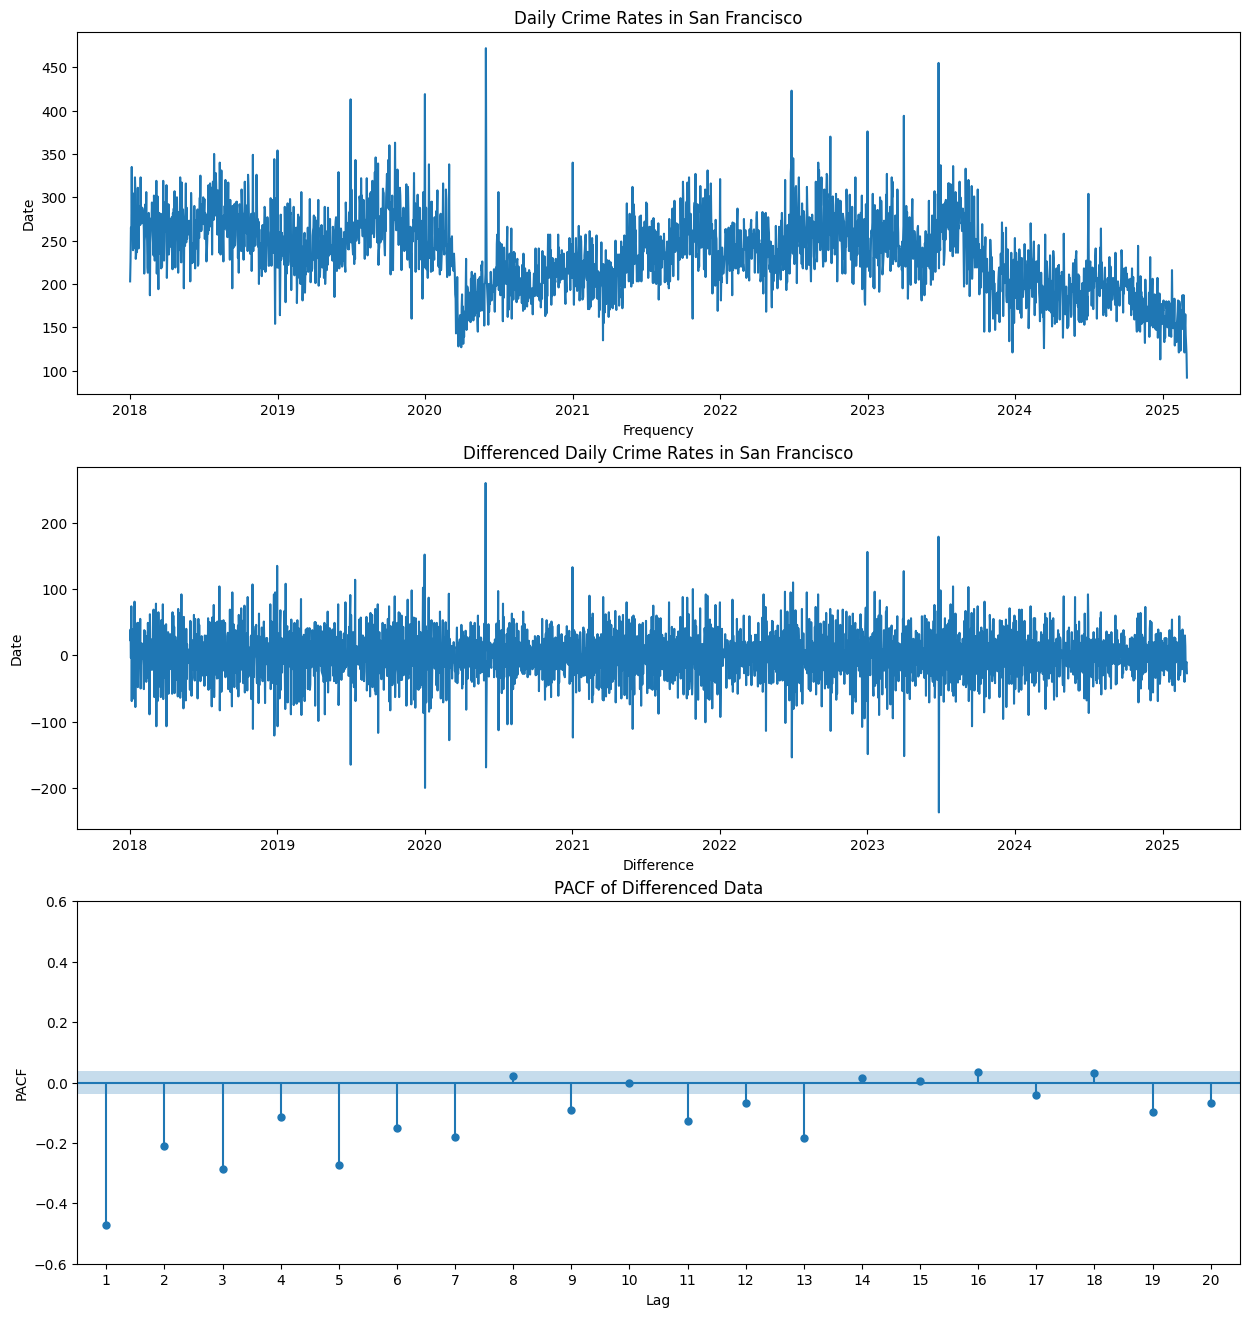

In [9]:
# analyzing data, stationarity, pacf
diff = ts['count'].diff(1)

fig, ax = plt.subplots(3,1, figsize=(15,16))

# plot of raw time series data
ax[0].plot(ts)
ax[0].set_title('Daily Crime Rates in San Francisco')
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Date')

# plot of differenced data
ax[1].plot(diff)
ax[1].set_title('Differenced Daily Crime Rates in San Francisco')
ax[1].set_xlabel('Difference')
ax[1].set_ylabel('Date')

# plot of pacf
plot_pacf(diff.dropna(), lags=20, ax=ax[2])
ax[2].set_title('PACF of Differenced Data')
ax[2].set_xticks(range(0,21))
ax[2].set_xlim(0.5, 20.5)
ax[2].set_ylim(-0.6, 0.6)
ax[2].set_xlabel('Lag')
ax[2].set_ylabel('PACF')

plt.show()

In [31]:
# data preprocessing pipeline
def preprocess_features(data):
    data = data.copy()
    # add diff
    data['diff1'] = data['count'].diff(1)
    # add target
    data['next'] = data['count'].shift(-1)

    # create lag features
    for lag in [1, 3, 5]:
        data[f'lag{lag}'] = data['count'].shift(lag)

    # create rolling means, stds, and trend
    ma = pd.DataFrame()
    mstd = pd.DataFrame()
    mtrend = pd.DataFrame()
    for window in [3, 7, 15, 30]:
        rolling = data['count'].rolling(window)
        ma[f'ma{window}'] = rolling.mean()
        mstd[f'mstd{window}'] = rolling.std()
        mtrend[f'mtrend{window}'] = ma[f'ma{window}'].diff(1)
    
    data = pd.concat([data, ma, mstd, mtrend], axis=1)
    
    return data

def preprocess_time(data):
    data = data.copy()
    # add time information, cyclical and linear
    data['year'] = data.index.year

    twopi = 2 * np.pi

    data['month'] = data.index.month
    x = data['month'] / 12
    data['month_sin'] = np.sin(twopi * x)
    data['month_cos'] = np.cos(twopi * x)

    data['day_year'] = data.index.dayofyear
    x = data['day_year'] / 365
    data['day_year_sin'] = np.sin(twopi * x)
    data['day_year_cos'] = np.cos(twopi * x)

    data['day_month'] = data.index.day
    days_per_month = data.index.days_in_month
    x = data['day_month'] / days_per_month
    data['day_month_sin'] = np.sin(twopi * x)
    data['day_month_cos'] = np.cos(twopi * x)

    data['day_week'] = data.index.dayofweek
    x = data['day_week'] / 7
    data['day_week_sin'] = np.sin(twopi * x)
    data['day_week_cos'] = np.cos(twopi * x)

    data['weekend'] = (data.index.weekday >= 5).astype(bool)
    data['holiday'] = (data.index.isin(holidays.US())).astype(bool)

    return data

def preprocess(data):
    data = preprocess_features(data)
    data = preprocess_time(data)

    return data

preprocess(ts).head()

,count,diff1,next,lag1,lag3,lag5,ma3,ma7,ma15,ma30,...,day_year_sin,day_year_cos,day_month,day_month_sin,day_month_cos,day_week,day_week_sin,day_week_cos,weekend,holiday
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01,203,NaN,226.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.017213,0.999852,1,0.201299,0.979530,0,0.000000,1.000000,False,False
2018-01-02,226,23.0,265.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.034422,0.999407,2,0.394356,0.918958,1,0.781831,0.623490,False,False
2018-01-03,265,39.0,261.0,226.0,NaN,NaN,231.333333,NaN,NaN,NaN,...,0.051620,0.998667,3,0.571268,0.820763,2,0.974928,-0.222521,False,False
2018-01-04,261,-4.0,335.0,265.0,203.0,NaN,250.666667,NaN,NaN,NaN,...,0.068802,0.997630,4,0.724793,0.688967,3,0.433884,-0.900969,False,False
2018-01-05,335,74.0,266.0,261.0,226.0,NaN,287.000000,NaN,NaN,NaN,...,0.085965,0.996298,5,0.848644,0.528964,4,-0.433884,-0.900969,False,False


In [66]:
# recursive prediction function
def predict_next_day(data, model):
    # predict 
    X = data.drop(labels=['next'], axis=1).iloc[-1]
    pred = model.predict([X])[0]

    # create new row
    nextdate = data.index[-1] + pd.Timedelta(days=1)
    last30 = pd.DataFrame(data['count'][-30:].copy())
    last30.loc[nextdate] = pred
    filled = preprocess(last30)
    filled = filled.drop(labels=['next'], axis=1)

    return filled.loc[nextdate]

# test model (naive)
class naive_forecast_model:
    def __init__(self):
        pass

    def predict(self, x):
        return [x[0]['count']]

naive_model = naive_forecast_model()
testdata = preprocess(ts)
predict_next_day(testdata, naive_model)

count                    92
diff1                   0.0
lag1                   92.0
lag3                  129.0
lag5                  165.0
ma3                   101.0
ma7                   127.0
ma15                  147.2
ma30             150.333333
mstd3             15.588457
mstd7             28.089144
mstd15            30.995852
mstd30            25.645237
mtrend3          -12.333333
mtrend7           -4.142857
mtrend15               -5.2
mtrend30               -2.1
year                   2025
month                     3
month_sin               1.0
month_cos               0.0
day_year                 62
day_year_sin       0.875892
day_year_cos       0.482508
day_month                 3
day_month_sin      0.571268
day_month_cos      0.820763
day_week                  0
day_week_sin            0.0
day_week_cos            1.0
weekend               False
holiday               False
Name: 2025-03-03 00:00:00, dtype: object

## Forecasting with XGBoost

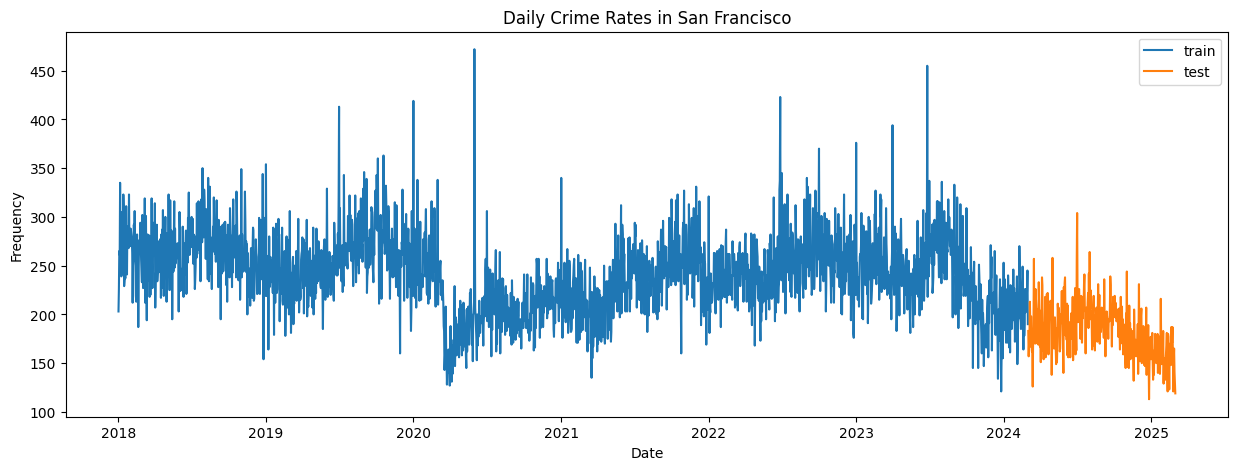

In [109]:
# simple train test split
tsdata = preprocess(ts)
tsdata = tsdata.iloc[:-1]
cutoff_date = tsdata.index[-1] - pd.Timedelta(days=365)
train = tsdata[tsdata.index <= cutoff_date].copy()
test = tsdata[tsdata.index > cutoff_date].copy()

fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(train['count'], label='train')
ax.plot(test['count'], label='test')
ax.set_title('Daily Crime Rates in San Francisco')
ax.set_ylabel('Frequency')
ax.set_xlabel('Date')
ax.legend()

plt.show()

In [63]:
trainX = train.drop(labels=['next'], axis=1)
trainY = train['next']
testX = test.drop(labels=['next'], axis=1)
testY = test['next']

xgb = XGBRegressor(n_estimators=500)
xgb.fit(trainX, trainY, eval_set=[(testX, testY)], verbose=50)

[0]	validation_0-rmse:51.67166
[50]	validation_0-rmse:32.87377
[100]	validation_0-rmse:33.95566
[150]	validation_0-rmse:34.28990
[200]	validation_0-rmse:34.27495
[250]	validation_0-rmse:34.30333
[300]	validation_0-rmse:34.30590
[350]	validation_0-rmse:34.30896
[400]	validation_0-rmse:34.31021
[450]	validation_0-rmse:34.31107
[499]	validation_0-rmse:34.31075


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

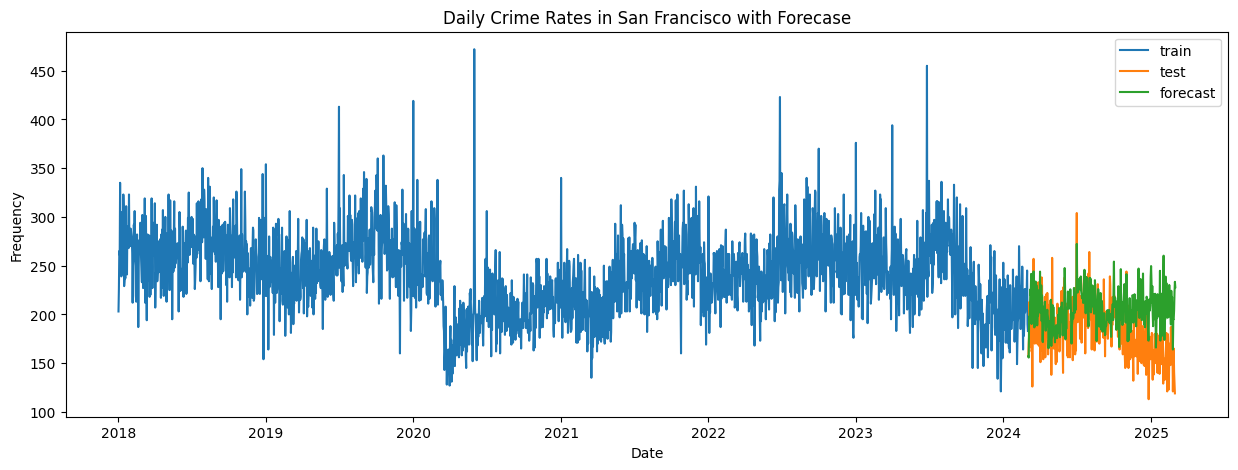

In [107]:
# visualize forecast
futures=train.copy()
n = 365
for i in range(n):
    newrow = predict_next_day(futures, xgb)
    newrow = pd.DataFrame(newrow).T
    futures = pd.concat([futures, newrow])

forecast_start = train.index[-1] + pd.Timedelta(days=1)

fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(train['count'], label='train')
ax.plot(test['count'], label='test')
ax.plot(futures[futures.index >= forecast_start]['count'], label='forecast')
ax.set_title('Daily Crime Rates in San Francisco with Forecase')
ax.set_xlabel('Date')
ax.set_ylabel('Frequency')
ax.legend()

plt.show()

## Finetuning XGB

In [125]:
def get_time_series_split(dates, test_len=365, n_folds=3):
    return [dates[-1] - pd.Timedelta(days=test_len*(n_folds-i)) for i in range(n_folds)]

def time_series_cv(data, model, test_len=365, n_folds=3):
    dates = get_time_series_split(data.index, test_len, n_folds)

    scores = []
    for date in dates:
        train = data[data.index <= date].copy()
        test = data[data.index > date].iloc[:test_len].copy()

        trainX = train.drop(labels=['next'], axis=1)
        trainY = train['next']
        testX = test.drop(labels=['next'], axis=1)
        testY = test['next']

        model.fit(trainX, trainY, eval_set=[(testX, testY)], verbose=0)
        preds = model.predict(testX)
        scores.append(root_mean_squared_error(testY, preds))
    return np.mean(scores)

# function closure for objective to pass in custom dataset
def xgb_objective_wrapper(data):
    def xgb_objective(trial):
        params = {
            'objective': 'reg:squarederror',
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 30),
            'min_child_weight': trial.suggest_float('min_child_weight', 0.01, 10),
            'gamma': trial.suggest_float('gamma', 0.0, 5.0),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
            'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-6, 10, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 10, log=True),
            'verbosity': 0
        }
    
        model = XGBRegressor(eval_metric='rmse',early_stopping_rounds=20,**params)
        kfscore = time_series_cv(data, model)
        return kfscore
    return xgb_objective

In [126]:
study = optuna.create_study(direction='minimize')
study.optimize(xgb_objective_wrapper(tsdata), n_trials=100, gc_after_trial=True)

best_params = study.best_params
print(f'Best params: {best_params}')
print(f'Best score: {study.best_value}')

[I 2025-05-14 17:21:05,268] A new study created in memory with name: no-name-13985822-0114-45f6-978c-8005e2539113


[I 2025-05-14 17:21:07,192] Trial 0 finished with value: 28.43770123839734 and parameters: {'n_estimators': 656, 'learning_rate': 0.02951800133907095, 'max_depth': 28, 'min_child_weight': 6.345171878005941, 'gamma': 4.241717117644009, 'subsample': 0.5250738200821774, 'colsample_bytree': 0.6945999165335133, 'colsample_bylevel': 0.7690835642674877, 'colsample_bynode': 0.6292708858340379, 'reg_alpha': 9.781270645085836e-05, 'reg_lambda': 0.00034250830329093614}. Best is trial 0 with value: 28.43770123839734.
[I 2025-05-14 17:21:09,717] Trial 1 finished with value: 28.78984811294084 and parameters: {'n_estimators': 576, 'learning_rate': 0.029475820059068587, 'max_depth': 23, 'min_child_weight': 9.125982881725655, 'gamma': 3.492736420497011, 'subsample': 0.9134841368733932, 'colsample_bytree': 0.6333158354895223, 'colsample_bylevel': 0.8195424046206197, 'colsample_bynode': 0.8694855250886109, 'reg_alpha': 2.4032104369867877e-05, 'reg_lambda': 2.0142442791461394e-06}. Best is trial 0 with va

Best params: {'n_estimators': 843, 'learning_rate': 0.0519298395945016, 'max_depth': 3, 'min_child_weight': 6.460583374996365, 'gamma': 1.430528901661625, 'subsample': 0.52206952252545, 'colsample_bytree': 0.8666007201939654, 'colsample_bylevel': 0.9229317614769335, 'colsample_bynode': 0.5182083115667707, 'reg_alpha': 0.0003084134747041668, 'reg_lambda': 1.0041607853598583e-06}
Best score: 27.35551469913133


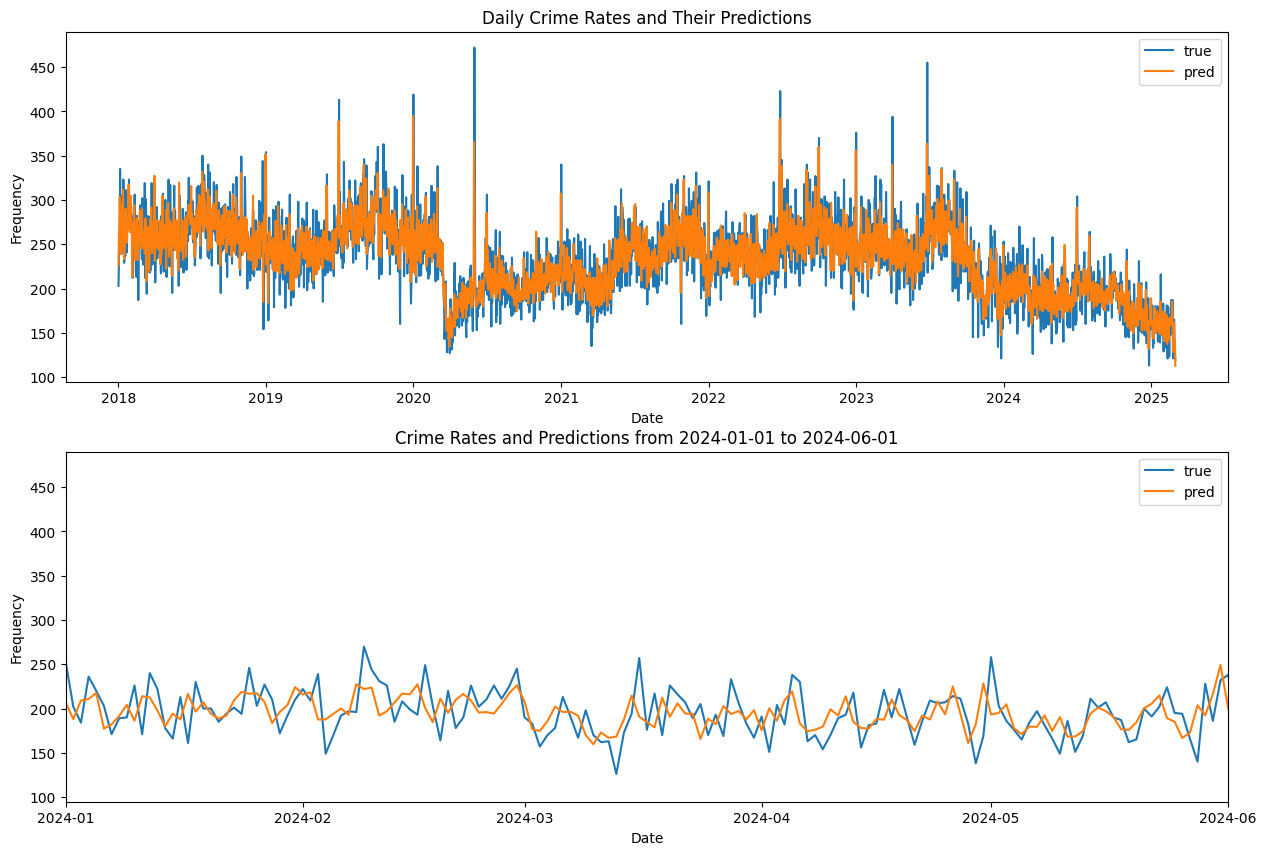

In [127]:
# visualizing the fit on training data
best_model = XGBRegressor(**best_params)
X = tsdata.drop(labels=['next'], axis=1)
Y = tsdata['next']

best_model.fit(X,Y)
preds = best_model.predict(X)

fig, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].plot(tsdata['count'], label='true')
ax[0].plot(tsdata.index, preds, label='pred')
ax[0].set_title('Daily Crime Rates and Their Predictions')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Frequency')
ax[0].legend()

# zooming in on particular set of dates
start_date = "2024-01-01"
end_date = "2024-06-01"

ax[1].plot(tsdata['count'], label='true')
ax[1].plot(tsdata.index, preds, label='pred')
ax[1].set_title(f'Crime Rates and Predictions from {start_date} to {end_date}')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
ax[1].legend()

plt.show()

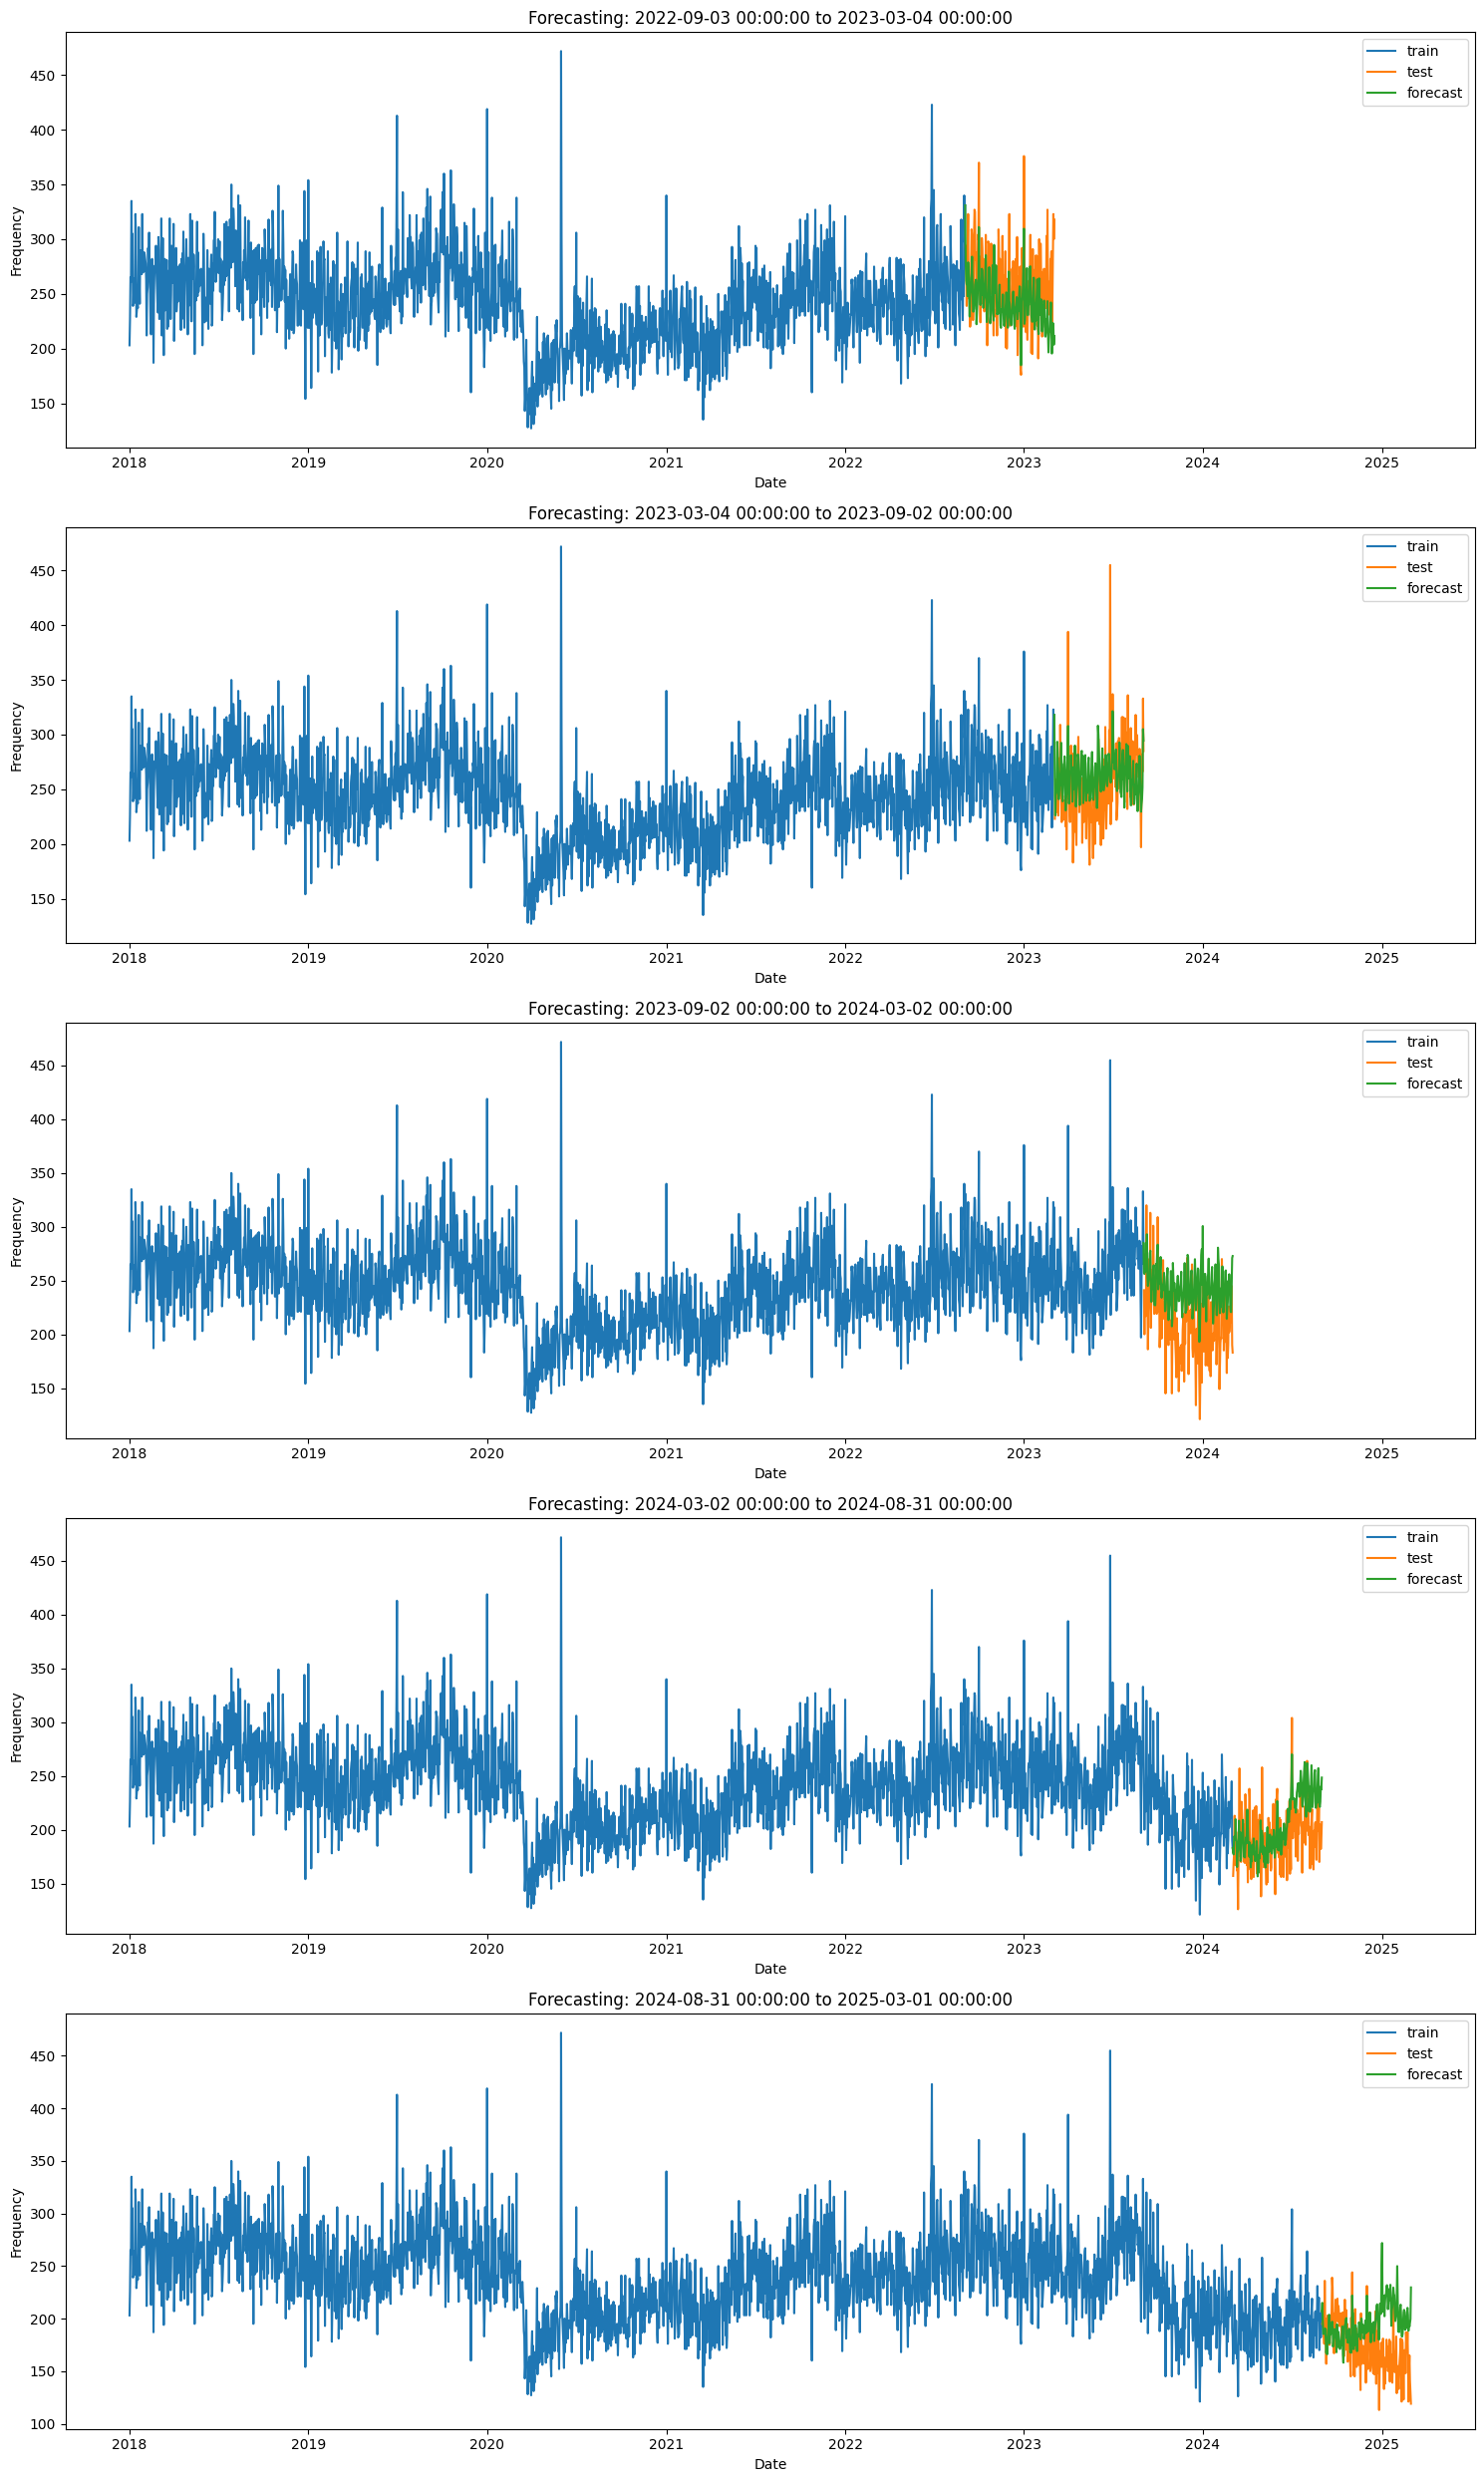

In [135]:
# visualizing performance of best model on each cv fold
best_model = XGBRegressor(**best_params)

n_folds = 5
test_len = 365 // 2
fig, ax = plt.subplots(n_folds, 1, figsize=(15, 5*n_folds), sharex=True)

dates = get_time_series_split(tsdata.index, test_len, n_folds)
for i in range(n_folds):
    date = dates[i]
    
    train = tsdata[tsdata.index <= date].copy()
    test = tsdata[tsdata.index > date].iloc[:test_len].copy()

    trainX = train.drop(labels=['next'], axis=1)
    trainY = train['next']
    testX = test.drop(labels=['next'], axis=1)
    testY = test['next']
    
    best_model.fit(trainX, trainY, verbose=0)

    futures = train.copy()
    for j in range(test_len):
        newrow = predict_next_day(futures, best_model)
        newrow = pd.DataFrame(newrow).T
        futures = pd.concat([futures, newrow])

    ax[i].plot(train['count'], label='train')
    ax[i].plot(test['count'], label='test')
    ax[i].plot(futures[futures.index >= date]['count'], label='forecast')
    ax[i].set_title(f'Forecasting: {date} to {date + pd.Timedelta(days=test_len)}')
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel('Frequency')
    ax[i].tick_params(labelbottom=True)
    ax[i].legend()

plt.tight_layout()
plt.show()

## Will Model Improve if we Handle Outliers
Want to model general trends in crime rates:
- not as interested in anomalies such as massive spikes in crimes on a single day due to some major event (such as George Floyd protests in early 2020)

In [ ]:
# figure out type of outlier handling: winsorize, z-score, or median absolute deviation filter
# apply filtering
# compare fitlered and original dataset
# retrain and evaluate model